In [1]:
run_optimization = False  # Here because the code in the notebook that optimizes is slow and painful to run often

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

reload(drift)
reload(metocean)
reload(simulator)
reload(plot)
reload(iceberg)
reload(test_case)
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [3]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plot_dir = './plots/'

# 20180928

# Read in Beacon Data 

In [4]:
df = sd.get_df(sd.beacon_dir_path + sd.beacon_csv_filenames[2])
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,90679,Solara,2015-04-24 15:21:03,NaN,51.46240,-51.55285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90679,Solara,2015-04-24 15:21:29,NaN,51.46174,-51.55156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90679,Solara,2015-04-24 15:21:57,NaN,51.46176,-51.55161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90679,Solara,2015-04-24 15:22:23,NaN,51.46177,-51.55165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90679,Solara,2015-04-24 15:22:55,NaN,51.46175,-51.55176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simulation

In [5]:
tc = test_case.TestCase()

In [6]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

Ca, Cw = 3, 0.1
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results1 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

Ca, Cw = 0.1, 5
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results2 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

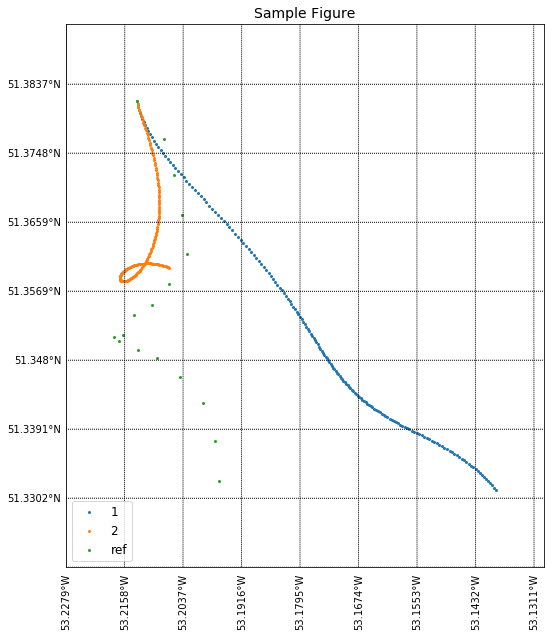

In [7]:
fig, ax = plot.plot_track([results1['latitude'].values, results1['longitude'].values],
                [results2['latitude'].values, results2['longitude'].values],
                [tc.ref_lats.values, tc.ref_lons.values], 
                s=4, labels = ['1', '2', 'ref'], title='Sample Figure'
)                

# Optimization

In [8]:
if run_optimization:
    
    keys = ['Ca', 'Cw']
    x0 = [1, 1]
    bounds = [[1, 2], [1,15]]
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

    optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

    optimization_result

## Simulation with Optimization Result

In [9]:
if run_optimization:

    Ca, Cw = optimization_result.x

    run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
    results = sim.run_simulation(**run_sim_kwargs)

    fig, ax = plot.plot_track([results['latitude'].values, results['longitude'].values],
                              [tc.ref_lats.values, tc.ref_lons.values], pads=[0.01]*4, s=4)

# Surface Optimization

In [10]:
if run_optimization:
    
    Ca_num = 3
    Cw_num = 3
    Ca_lower_bound = 1; Ca_upper_bound = 5
    Cw_lower_bound = 5; Cw_upper_bound = 16

    scaling = 'lin'

    if scaling == 'log':

        Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
        Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

    elif scaling == 'lin':

        Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
        Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


    Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [11]:
if run_optimization:
    
    mse_matrix = np.zeros((Ca_num, Cw_num))
    keys = ['Ca', 'Cw']
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    for i in range(Ca_num):
        for j in range(Cw_num):
            form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
            mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)

In [12]:
if run_optimization:

    fig = plt.figure(figsize=(14,7))

    plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix)#, vmin=0.02525, vmax=0.02675)

    plt.xticks(Ca_vec)#, rotation='vertical')
    plt.yticks(Cw_vec)

    plt.xlabel('Ca')
    plt.ylabel('Cw')

    plt.colorbar()

    plt.show()

# 20181011

# Ekman

In [13]:
label = 'ekman'

# No Ekman
ekman = False
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='no_ekman', **kwargs)

# Ekman to depth of 100 m
ekman = True
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='ekman_100', **kwargs)

# Ekman to depth of 1000 m
ekman = True
depth_vec = np.arange(0, -1100, -100)
kwargs = {'ekman': ekman, 'depth_vec': depth_vec}
xds = sim.run_simulation(store_results_as='ekman_1000', **kwargs)

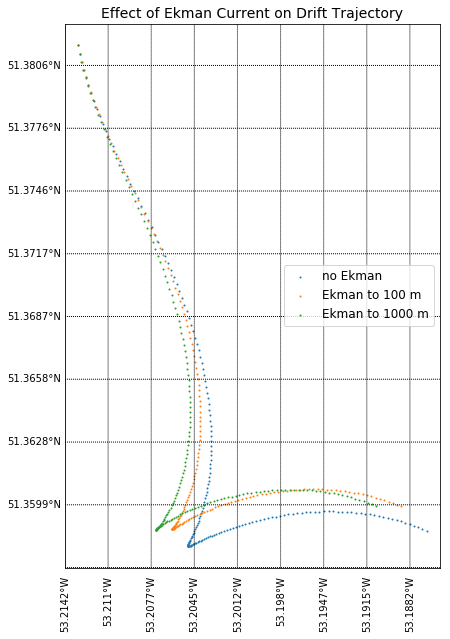

In [14]:
title = 'Effect of Ekman Current on Drift Trajectory'
pads = [0.001] * 4
labels = ['no Ekman', 'Ekman to 100 m', 'Ekman to 1000 m']
kwargs = {'pads': pads, 'labels': labels, 'title': title}
fig, ax = sim.plot_track(['no_ekman', 'ekman_100', 'ekman_1000'], **kwargs)
fig.savefig(plot_dir + label + '.png')

# Testing Drift Model with Constant Metocean Fields

In [15]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

## Default

In [16]:
label = 'default'
xds = sim.run_simulation(store_results_as=label)

In [17]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

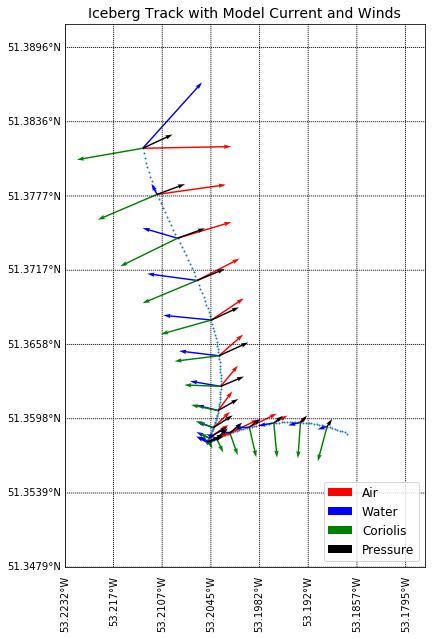

In [18]:
title = 'Iceberg Track with Model Current and Winds'

arrow_colors = ['red', 'blue', 'green', 'black']
arrow_labels = ['Air', 'Water', 'Coriolis', 'Pressure']

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

arrow_scale = 5e5
autoscale_figure = False
pads = [0.01] * 4 
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads}


fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## No Current, Constant Wind

In [19]:
label = 'no_current_constant_wind'
sim.start_velocity = 0, 0
sim.set_constant_currents((0, 0))
sim.set_constant_winds((10, 0))
xds = sim.run_simulation(store_results_as=label)

In [20]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

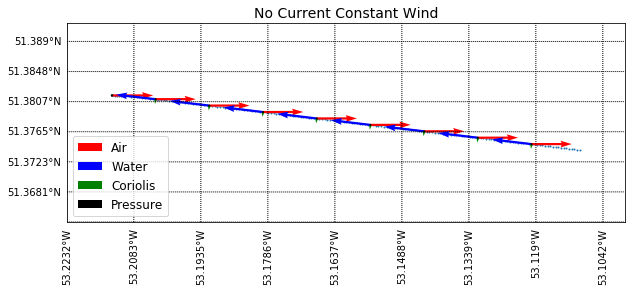

In [21]:
title = 'No Current Constant Wind'

arrow_scale = 1e7
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.01] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## No Wind, Constant Current

In [22]:
label = 'no_wind_constant_current'
sim.start_velocity = 0.1, 0
sim.set_constant_currents((0.1, 0))
sim.set_constant_winds((0, 0))
xds = sim.run_simulation(store_results_as=label)

In [23]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

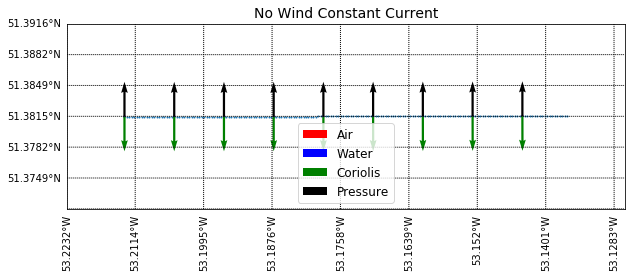

In [24]:
title = 'No Wind Constant Current'

arrow_scale = 1e6
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.01] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## No Wind or Current

In [25]:
label = 'no_wind_or_current'
sim.start_velocity = tc.start_velocity
sim.set_constant_currents((0, 0))
sim.set_constant_winds((0, 0))
xds = sim.run_simulation(store_results_as=label)

In [26]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

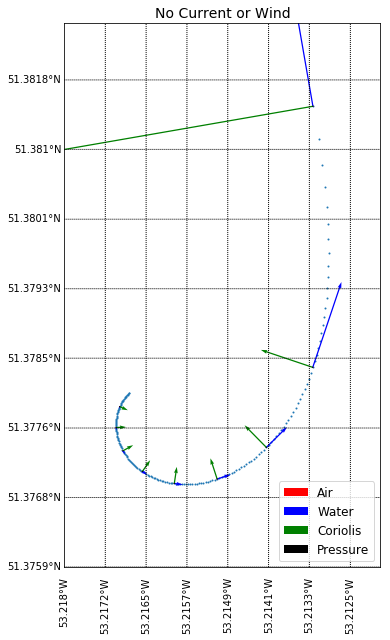

In [27]:
title = 'No Current or Wind'

arrow_scale = 1e5
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.001] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

## Constant Current and Wind

In [28]:
label = 'constant_current_and_wind'
sim.start_velocity = 0, 0
sim.set_constant_currents((0.1, 0))
sim.set_constant_winds((10, 0))
xds = sim.run_simulation(store_results_as=label)

In [29]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

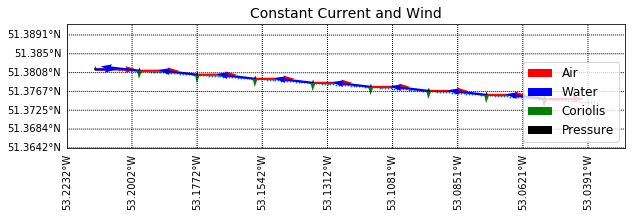

In [30]:
title = 'Constant Current and Wind'

arrow_scale = 1e7
autoscale_figure = False

vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
          [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]

pads = [0.01] * 4 
gap = 20
kwargs = {'vectors': vectors, 'arrow_colors': arrow_colors, 'arrow_labels': arrow_labels, 
          'autoscale_figure': autoscale_figure, 'arrow_scale': arrow_scale, 'title': title, 'pads': pads, 
         'gap': gap}

fig, ax = sim.plot_track([label], **kwargs)
fig.savefig(plot_dir + label + '.png')

# Varying Berg Size

In [31]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [32]:
sizes = ['SM', 'MED', 'LG', 'VLG']
labels = ['SM', 'MED', 'LG', 'VLG']

for size, label in zip(sizes, labels):

    sim.iceberg_size = size
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)
    

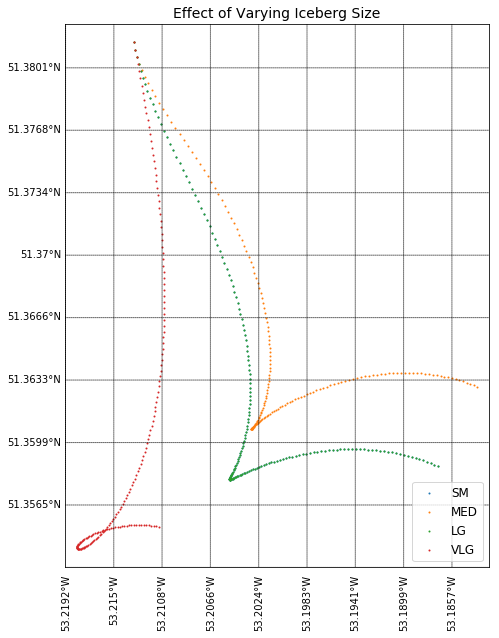

In [33]:
title = 'Effect of Varying Iceberg Size'
pads = [0.001] * 4
kwargs = {'pads': pads, 'labels': labels, 'title': title}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'sizes' + '.png')

In [61]:
size_class = 'LG'
min_length, max_length = iceberg.WATERLINE_LENGTH_RANGE_BY_SIZE[size_class]
min_height, max_height = iceberg.SAIL_HEIGHT_RANGE_BY_SIZE[size_class]

In [63]:
num_intervals = 10
lengths = np.linspace(min_length, max_length, num_intervals)
heights = np.linspace(min_height, max_height, num_intervals)
labels = []

for length, height in zip(lengths, heights):
    
    label = '{},{}'.format(int(length), int(height))
    labels.append(label)
    sim.iceberg_size = length, height
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)    

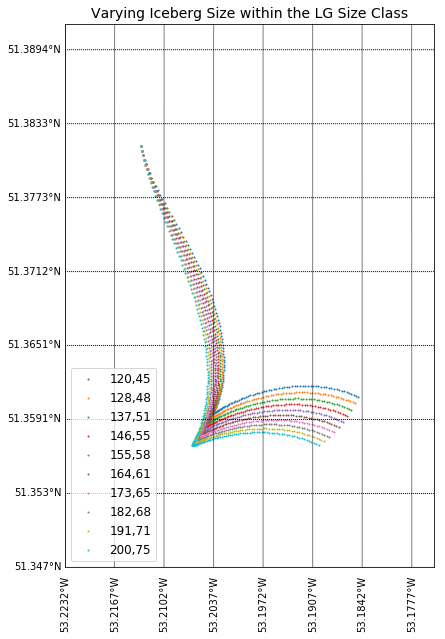

In [67]:
title = f'Varying Iceberg Size within the {size_class} Size Class'
kwargs = {'title': title, 'labels': labels}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + f'{size_class}_size_range.png')

# Varying Berg Shape

In [34]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [35]:
shapes = ['TAB', 'NTAB', 'DOM', 'PIN', 'WDG', 'DD', 'BLK']
labels = ['TAB', 'NTAB', 'DOM', 'PIN', 'WDG', 'DD', 'BLK']

for shape, label in zip(shapes, labels):

    sim.iceberg_shape = shape
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)


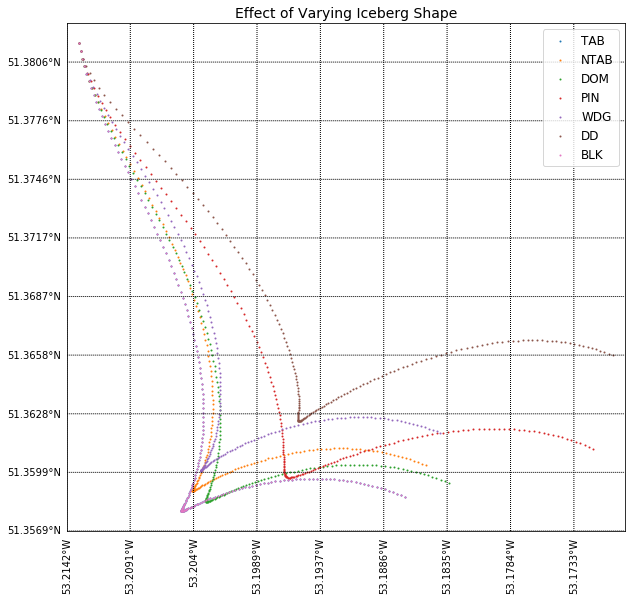

In [36]:
title = 'Effect of Varying Iceberg Shape'
pads = [0.001] * 4
kwargs = {'pads': pads, 'labels': labels, 'title': title}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'shapes' + '.png')

# Effect of changing timestepper

In [37]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [38]:
label = 'euler'
xds = sim.run_simulation(store_results_as=label)

In [39]:
label = 'rk2'
sim.time_stepper = timesteppers.rk2
xds = sim.run_simulation(store_results_as=label)

In [40]:
label = 'rk4'
sim.time_stepper = timesteppers.rk4
xds = sim.run_simulation(store_results_as=label)

In [41]:
label = 'ab2'
sim.time_stepper = timesteppers.ab2
xds = sim.run_simulation(store_results_as=label)

In [42]:
label = 'ab3'
sim.time_stepper = timesteppers.ab3
xds = sim.run_simulation(store_results_as=label)

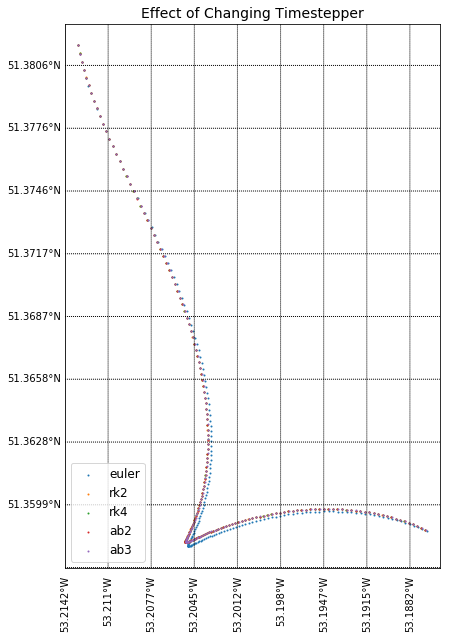

In [43]:
title = 'Effect of Changing Timestepper'
labels = ['euler', 'rk2', 'rk4', 'ab2', 'ab3']
pads = [0.001] * 4
kwargs = {'labels': labels, 'pads': pads, 'title': title}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'timesteppers' + '.png')

# AVOS

In [44]:
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [45]:
avos_ds = sd.get_avos_ds() 

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


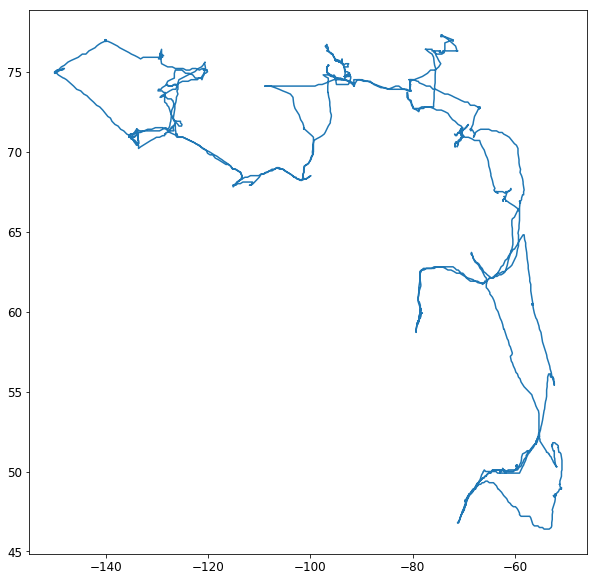

In [46]:
plt.plot(avos_ds['longitude'], avos_ds['latitude'])

In [47]:
avos_ds = avos_ds.assign_coords(latitude=avos_ds['latitude'].values)
avos_ds = avos_ds.assign_coords(longitude=avos_ds['longitude'].values)

# ADCP

In [49]:
adcp_ds = sd.get_adcp_ds()

In [50]:
adcp_time_frame = adcp_ds.time.values[0], adcp_ds.time.values[-1] 
ocean = metocean.Ocean(adcp_time_frame)

Attempting to download http://icedef.munroelab.ca/data/ECMWF/ocean/daily/20150504.nc... done.


In [51]:
df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
for i in range(len(adcp_ds.time)):
    t = adcp_ds.time[i].values
    x = adcp_ds.longitude[i].values
    y = adcp_ds.latitude[i].values
    u = adcp_ds.eastward_velocity[i, 0].values
    v = adcp_ds.northward_velocity[i, 0].values
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = ocean.current.interpolate((t, y, x))
                    df.loc[len(df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

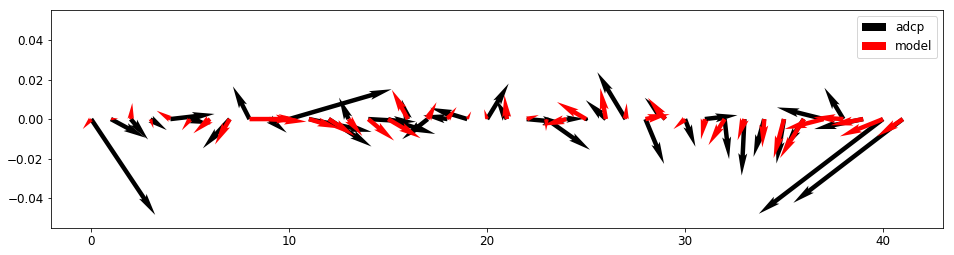

In [52]:
plt.figure(figsize=(16, 4))
gap = 30
width = 0.005
headwidth = 2
scale = 4
kwargs = {'width': width, 'headwidth': headwidth, 'scale': scale}
plt.quiver(df.u[::gap], df.v[::gap], label='adcp', **kwargs)
plt.quiver(df.iu[::gap], df.iv[::gap], color='red', label='model', **kwargs)
plt.legend()
plt.show()

# AVOS

In [56]:
avos_df = sd.get_avos_df()

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


In [53]:
avos_time_frame = avos_ds.time.values[0], adcp_time_frame[1]

In [54]:
atm = metocean.Atmosphere(avos_time_frame)

Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150416.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150417.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150418.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150502.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150503.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150504.nc... done.


In [57]:
atm_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
for i in range(len(avos_df.loc[avos_df.time < adcp_time_frame[1]])):
    t = avos_ds.time[i].values
    x = avos_ds.longitude[i].values
    y = avos_ds.latitude[i].values
    u = avos_ds.eastward_velocity[i].values
    v = avos_ds.northward_velocity[i].values
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = atm.wind.interpolate((t, y, x))
                    atm_df.loc[len(atm_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

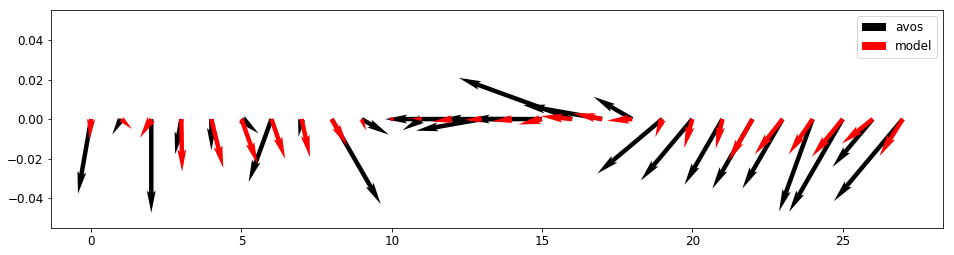

In [58]:
plt.figure(figsize=(16, 4))
gap = 10
width = 0.005
headwidth = 2
scale = 200
kwargs = {'width': width, 'headwidth': headwidth, 'scale': scale}
plt.quiver(atm_df.u[::gap], atm_df.v[::gap], label='avos', **kwargs)
plt.quiver(atm_df.iu[::gap], atm_df.iv[::gap], color='red', label='model', **kwargs)
plt.legend()
plt.show()